In [39]:
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torch

from PIL import Image
from tqdm import tqdm
import shutil

from sklearn.model_selection import train_test_split
import time

## Loading Datasets

In [41]:
def get_labels_df(labels_dir,images_dir,labels_dict,resize_shape):

    txt_files = [f for f in os.listdir(labels_dir) if f.endswith('.txt')]
    fileID_list = []
    content_list = []
    for file_name in tqdm(txt_files):
        # Read the contents of the .txt file
        with open(os.path.join(labels_dir, file_name), 'r') as file:
            content = file.read().strip()
            # print(content)
            content_float = [float(val) for val in content.split()]

            fileID = file_name[:-4] # removing .txt

            fileID_list.append(fileID)

            # Open an image from file
            image = cv2.imread(images_dir+fileID+'.jpeg')
            image = cv2.resize(image, resize_shape)
            img_height = image.shape[0]
            img_width = image.shape[1]

            center_x = content_float[1]*img_width
            center_y = content_float[2]*img_height
            bbx_width = content_float[3]*img_width
            bbx_height = content_float[4]*img_height
            x1 = int(center_x - bbx_width / 2)
            y1 = int(center_y - bbx_height / 2)
            x2 = int(center_x + bbx_width / 2)
            y2 = int(center_y + bbx_height / 2)

            corner_coords = [x1,y1,x2,y2,img_width,img_height]
            content_list.append(content_float+corner_coords)


            # print(image.shape)

    labels_df = pd.DataFrame(np.array(content_list),columns=['class_label','bbx_xcenter','bbx_ycenter','bbx_width','bbx_height','x1','y1','x2','y2','img_width','img_height'])
    labels_df['class_label']+=1
    labels_df['fileID'] = fileID_list
    labels_df['LabelName'] = labels_df['class_label'].apply(lambda x: labels_dict[int(x)])
    # labels_df = labels_df.set_index('fileID')

    return labels_df


In [43]:
labels_dict = {1:"aegypti",
               2:"albopictus",
               3:"anopheles",
               4:"culex",
               5:"culiseta",
               6:"japonicus/koreicus"}

# Mention the Path to Training Set Labels and Training Set Images
labels_dir = '/kaggle/input/sample-data-7500/Sample_Data_7500/train_labels/'
images_dir = '/kaggle/input/sample-data-7500/Sample_Data_7500/train_images/'

resize_shape = (512,512)
labels_df = get_labels_df(labels_dir,images_dir,labels_dict,resize_shape)

100%|██████████| 7500/7500 [01:38<00:00, 76.01it/s]


In [7]:
labels_df

,class_label,bbx_xcenter,bbx_ycenter,bbx_width,bbx_height,x1,y1,x2,y2,img_width,img_height,fileID,LabelName
0,4.0,0.498047,0.449817,0.931641,0.451282,16.0,114.0,493.0,345.0,512.0,512.0,efb950ca-0c2d-4fef-a974-33d1ca86ff7a,culex
1,6.0,0.450376,0.425998,0.308738,0.229601,151.0,159.0,309.0,276.0,512.0,512.0,06d7a3ba-f4b0-4972-91ca-4d7de01e8f81,japonicus/koreicus
2,2.0,0.430556,0.508363,0.472222,0.369176,99.0,165.0,341.0,354.0,512.0,512.0,d28d088c-783f-460a-85bb-297835929fd3,albopictus
3,4.0,0.500000,0.528320,0.203125,0.132812,204.0,236.0,308.0,304.0,512.0,512.0,43c2b6d9-95a6-4596-8cfa-f6977a53e4ae,culex
4,4.0,0.417989,0.155010,0.242725,0.139881,151.0,43.0,276.0,115.0,512.0,512.0,3e6e372b-8574-45eb-bd4f-75646b3f06da,culex
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3695,4.0,0.305000,0.423333,0.300000,0.383333,79.0,118.0,232.0,314.0,512.0,512.0,19b5279d-3c8b-409c-871d-4c93f95e189f,culex
3696,2.0,0.527344,0.625275,0.103516,0.071062,243.0,301.0,296.0,338.0,512.0,512.0,644d11c5-7cec-45f5-95ee-e6a5c32a3dd1,albopictus
3697,4.0,0.490885,0.498047,0.182292,0.107422,204.0,227.0,298.0,282.0,512.0,512.0,c1d122a9-e975-416d-898b-52ec55e4990c,culex
3698,4.0,0.598710,0.513145,0.421627,0.307044,198.0,184.0,414.0,341.0,512.0,512.0,63089dc3-88d6-462d-b70b-1907a2ca6718,culex


In [8]:
labels_freq = labels_df.LabelName.value_counts()
labels_freq

LabelName
culex                 1500
albopictus            1500
culiseta               400
japonicus/koreicus     220
anopheles               50
aegypti                 30
Name: count, dtype: int64

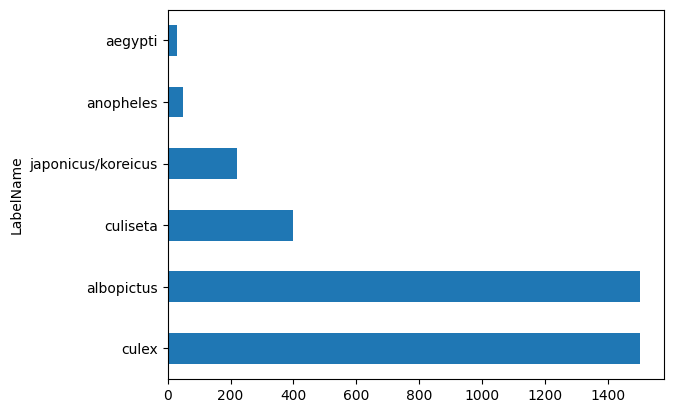

In [9]:
labels_freq.plot(kind='barh')
plt.show()


In [ ]:
num_files = 5 # Number of Image files per class
images_plt = {label_name:[] for label_name in labels_dict.values()}
sample_fileID_dict = {}

for label_name in labels_dict.values():
    fileID_list = labels_df[labels_df['LabelName']==label_name].fileID
    sample_fileID_dict[label_name] = fileID_list[:num_files]
    for fileID in fileID_list[:num_files]:
        img = cv2.imread(images_dir+fileID+'.jpeg')
        img = cv2.resize(img,resize_shape)
        h,w = img.shape[0],img.shape[1]
        fileID_row = labels_df[labels_df.fileID==fileID]

        x1,y1,x2,y2 = int(fileID_row.x1),int(fileID_row.y1),int(fileID_row.x2),int(fileID_row.y2)
        # # Draw the bounding box rectangle on the image
        cv2.rectangle(img, (x1,y1), (x2,y2), (0, 255, 0), int(w*0.01))
        # cv2.circle(img,(int(center_x),int(center_y)),int(w*0.01),(255,0, 0),int(w*0.01))
        images_plt[label_name].append(img)


In [ ]:
fig,axes = plt.subplots(6,num_files,figsize=(25,20))

for row,label_name in enumerate(labels_dict.values()):
    for col,img in enumerate(images_plt[label_name]):
        axes[row][col].imshow(img)
        axes[row][col].set_title(label_name)
        axes[row][col].axis('off')

plt.tight_layout()

## Data Loader for Faster RCNN

In [45]:
class FasterRNNDatset:
    def __init__(self,labels_df,images_dir,resize_shape):
        self.labels_df = labels_df
        self.images_dir = images_dir
        self.resize_shape = resize_shape

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self,idx):
        df_row = self.labels_df.iloc[idx]
        fileID = df_row.fileID
        x1 = df_row.x1
        y1 = df_row.y1
        x2 = df_row.x2
        y2 = df_row.y2
        class_label = df_row.class_label

        img_path = self.images_dir + fileID + '.jpeg'
        img = Image.open(img_path).convert('RGB').resize(self.resize_shape)

        img_tensor = T.ToTensor()(img)

        boxes = torch.tensor([[x1,y1,x2,y2]],dtype=float)
        labels = torch.tensor([class_label],dtype=torch.int64)
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels

        return img_tensor,target

In [46]:
train_test_split_ratio = 0.2
batch_size = 16
shuffle = True
resize_shape = resize_shape # Defined earlier, ensure same in labels_df and Dataset Folder

train_df,val_df = train_test_split(labels_df,shuffle=True,test_size = train_test_split_ratio)

train_dataset = FasterRNNDatset(train_df,images_dir,resize_shape)
val_dataset = FasterRNNDatset(val_df,images_dir,resize_shape)

train_dl = torch.utils.data.DataLoader(train_dataset,
                                       batch_size = batch_size,
                                       shuffle=shuffle,
                                       pin_memory = True if torch.cuda.is_available() else False)

val_dl = torch.utils.data.DataLoader(val_dataset,
                                     batch_size=batch_size,
                                     shuffle=shuffle,
                                     pin_memory = True if torch.cuda.is_available() else False)

In [47]:
train_df.class_label.value_counts()

class_label
4.0    2663
2.0    2654
5.0     360
6.0     245
3.0      47
1.0      31
Name: count, dtype: int64

In [48]:
val_df.class_label.value_counts()

class_label
2.0    680
4.0    649
5.0    100
6.0     55
3.0     12
1.0      4
Name: count, dtype: int64

## Faster RCNN Model

In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)

# 6 Mosquito Classes and 1 for background
num_classes = 7 
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [2]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [50]:
lr = 0.01
momentum = 0.9
weight_decay = 0.0005
num_epochs = 10
optimizer = torch.optim.SGD(model.parameters(),lr = lr,momentum=momentum,weight_decay=weight_decay)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [52]:
model.to(device)
history = {'Train Loss':[],
            'Val Loss':[]}
for epoch in range(num_epochs):
    t1 = time.time()

    epoch_loss_train_list = []
    epoch_loss_val_list = []
    model.train()
    for data in tqdm(train_dl):

        images = data[0].to(device) #Converting it to a list of images
        boxes = data[1]['boxes']
        labels = data[1]['labels']
        targets = []
        for i in range(len(images)):
            d = {}
            d['boxes'] = boxes[i].to(device)
            d['labels'] = labels[i].to(device)
            targets.append(d)

        # Now we have list of images and targets

        # print((targets[0]['boxes']).shape)
        # print((targets[0]['labels']).shape)
        # model.train()
        loss_dict = model(images,targets)
        loss = sum(v for v in loss_dict.values())
        epoch_loss_train_list.append(loss.cpu().detach().numpy())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    t2 =time.time()

    with torch.no_grad():
        for data in tqdm(val_dl):

            images = data[0].to(device) #Converting it to a list of images
            boxes = data[1]['boxes']
            labels = data[1]['labels']
            targets = []
            for i in range(len(images)):
                d = {}
                d['boxes'] = boxes[i].to(device)
                d['labels'] = labels[i].to(device)
                targets.append(d)

            loss_dict = model(images,targets)
            loss = sum(v for v in loss_dict.values())
            
            epoch_loss_val_list.append(loss.cpu().detach().numpy())
    t3 =time.time()
    epoch_loss_train = sum(epoch_loss_train_list)/len(epoch_loss_train_list)
    epoch_loss_val = sum(epoch_loss_val_list)/len(epoch_loss_val_list)
    print("Epoch: {} | Epoch Loss Train: {:.3f} | Epoch Loss Val: {:.3f} | Train Time: {:.2f} | Val Time{:.2f}".format(epoch,epoch_loss_train,epoch_loss_val,t2-t1,t3-t2))
    history['Train Loss'].append(epoch_loss_train)
    history['Val Loss'].append(epoch_loss_val)


100%|██████████| 94/94 [01:16<00:00,  1.23it/s]


Epoch: 0 | Epoch Loss Train: 0.073 | Epoch Loss Val: 0.087 | Train Time: 546.52 | Val Time76.64


100%|██████████| 94/94 [01:16<00:00,  1.23it/s]

Epoch: 1 | Epoch Loss Train: 0.068 | Epoch Loss Val: 0.087 | Train Time: 547.29 | Val Time76.42


#### Saving Model

In [54]:
model_save_path = '/kaggle/working/'+'model_state_sample7500_10epoch.pth'
torch.save(model.state_dict(),model_save_path)

### Evaluation

In [14]:
model_save_path = '/kaggle/working/'+'model_state_sample7500_10epoch.pth'

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
num_classes = 7
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

state_dict = torch.load(model_save_path)
model.load_state_dict(state_dict)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

### Generating submission file

In [2]:
submission_df = pd.read_csv('/kaggle/input/submission-file/sample_submission.csv',index_col=False)
submission_df

,id,ImageID,LabelName,Conf,xcenter,ycenter,bbx_width,bbx_height
0,0,16dbbc39-fcb6-498e-963f-d3807fcc3cec.jpeg,albopictus,0.5,0.1,0.2,0.3,0.4
1,1,7daa68bd-928b-4b43-850f-4626f16d2c14.jpeg,albopictus,0.5,0.1,0.2,0.3,0.4
2,2,bb0986d9-fa04-40a5-8de2-c54045537e17.jpeg,albopictus,0.5,0.1,0.2,0.3,0.4
3,3,11924d04-69fe-469d-8d1c-119bc0f0b94f.jpeg,albopictus,0.5,0.1,0.2,0.3,0.4
4,4,db4ade79-fce4-4d77-a8fa-36b9e77dfd08.jpeg,albopictus,0.5,0.1,0.2,0.3,0.4
...,...,...,...,...,...,...,...,...
520,520,b719ddba-3666-4dfd-848b-afe465d4dd5c.jpeg,albopictus,0.5,0.1,0.2,0.3,0.4
521,521,87573bc0-f7fd-4da6-b085-c331d740039f.jpeg,albopictus,0.5,0.1,0.2,0.3,0.4
522,522,3a918cb9-770c-4e13-8201-90858c25c7d0.jpeg,albopictus,0.5,0.1,0.2,0.3,0.4
523,523,da0226ce-ef8f-4217-bd5d-38955a232eab.jpeg,albopictus,0.5,0.1,0.2,0.3,0.4


In [32]:
def get_row(prediction,labels_dict):
    if prediction['boxes'].shape[0]==0:
        label = 2
        score = 0.5
        xcenter = 0.5
        ycenter = 0.5
        bbx_width = 1
        bbx_height = 1

    else:
        box = prediction['boxes'][0].cpu().detach().numpy()
        score = prediction['scores'][0].item()
        label = prediction['labels'][0].item()

        box_width = box[2]-box[0]
        box_height = box[3]-box[1]

        box_centre_x = box[0]+box_width/2
        box_centre_y = box[1]+box_height/2

        xcenter = box_centre_x/resize_shape[0]
        ycenter = box_centre_y/resize_shape[1]
        bbx_width = box_width/resize_shape[0]
        bbx_height = box_height/resize_shape[1]

    row = [labels_dict[label],score,xcenter,ycenter,bbx_width,bbx_height]
    return row

In [3]:
def get_ans_dict(model,test_set_dir,submission_df):
    submission_columns = submission_df.columns
    imageID_list = submission_df.ImageID
#     test_set_dir = '/kaggle/input/test-enhanced/test_enhanced/'

    model.to(device)
    ans_dict = {col:[] for col in submission_columns}
    for Id,imageID in (enumerate(imageID_list)):
        img_path = test_set_dir+imageID
        img = Image.open(img_path).convert('RGB').resize(resize_shape)
        img_tensor = T.ToTensor()(img)

        model.eval()
        # images_test.append(img_tensor)

        predictions = model([img_tensor.to(device)])
        row = get_row(predictions[0],labels_dict)

        print("id: {} | Label | {} | Score: {}".format(Id,row[0],row[1]))

        ans_dict['id'].append(Id)
        ans_dict['ImageID'].append(imageID)
        ans_dict['LabelName'].append(row[0])
        ans_dict['Conf'].append(row[1])
        ans_dict['xcenter'].append(row[2])
        ans_dict['ycenter'].append(row[3])
        ans_dict['bbx_width'].append(row[4])
        ans_dict['bbx_height'].append(row[5])
        
    return ans_dict

In [4]:
test_set_dir = '/kaggle/input/test-enhanced/test_enhanced/'
ans_dict = get_ans_dict(model, test_set_dir,submission_df)

id: 0 | Label | albopictus | Score: 0.9781951308250427
id: 1 | Label | albopictus | Score: 0.9903497695922852
id: 2 | Label | albopictus | Score: 0.9908469319343567
id: 3 | Label | culex | Score: 0.9252532720565796
id: 4 | Label | culex | Score: 0.9236802458763123
id: 5 | Label | culex | Score: 0.843659520149231
id: 6 | Label | albopictus | Score: 0.9400508999824524
id: 7 | Label | albopictus | Score: 0.9700546860694885
id: 8 | Label | albopictus | Score: 0.9872851967811584
id: 9 | Label | culex | Score: 0.9260343313217163
id: 10 | Label | albopictus | Score: 0.9840559959411621
id: 11 | Label | culex | Score: 0.9875020980834961
id: 12 | Label | culex | Score: 0.7237969636917114
id: 13 | Label | culex | Score: 0.9186680912971497
id: 14 | Label | culex | Score: 0.837162971496582
id: 15 | Label | culex | Score: 0.5860195755958557
id: 16 | Label | albopictus | Score: 0.9810104966163635
id: 17 | Label | culex | Score: 0.993269145488739
id: 18 | Label | culex | Score: 0.9840059876441956
id: 

In [5]:
sum(ans_dict['Conf'])/len(ans_dict['Conf'])

0.9191072730649086

In [7]:
pd.DataFrame(ans_dict).to_csv('faster_rcnn_sub6.csv',index=False)

# Rough

### Reference Working Code for Training Pipeline


In [ ]:
model_ref = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 7
in_features = model_ref.roi_heads.box_predictor.cls_score.in_features
model_ref.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
# For training
num_bbx = 8
images_ref, boxes_ref = torch.rand(4, 3, 600, 1200), torch.rand(4, num_bbx, 4)
boxes_ref[:, :, 2:4] = boxes_ref[:, :, 0:2] + boxes_ref[:, :, 2:4]
labels_ref = torch.randint(1, num_classes, (4, num_bbx))
images_ref = list(image for image in images_ref)
targets_ref = []
for i in range(len(images_ref)):
    d = {}
    d['boxes'] = boxes_ref[i]
    d['labels'] = labels_ref[i]
    targets_ref.append(d)
output = model_ref(images_ref, targets_ref)
# For inference
model_ref.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model_ref(x)
# optionally, if you want to export the model to ONNX:
# torch.onnx.export(model, x, "faster_rcnn.onnx", opset_version = 11)

In [ ]:
targets_ref[0]['boxes'].shape

### Code used to Copy a subset of the data to a new folder (For Debugging Purposes)


In [ ]:
# sample_img_dir = 'Sample_Data/train_images/'
# sample_label_dir = 'Sample_Data/train_labels/'
# for label_name in labels_dict.values():
#     fileID_list = sample_fileID_dict[label_name]
#     for fileID in (fileID_list):
#         img_path1 = 'Brightened Data Set/train_images/'+fileID+'.jpeg'
#         img_path2 = sample_img_dir+fileID+'.jpeg'

#         labels_path1 = 'Brightened Data Set/train_labels/'+fileID+'.txt'
#         labels_path2 = sample_label_dir+fileID+'.txt'
#         # img = cv2.imread()
#         shutil.copyfile(img_path1, img_path2)
#         shutil.copyfile(labels_path1, labels_path2)